In [1]:
import numpy as np
import math
import matplotlib as mpl
import matplotlib.pyplot as plt
plt.style.use('seaborn-deep')
from mpl_toolkits import mplot3d as mpl3d
from scipy import signal, stats, linalg, fft
import tqdm

# import our 'specsens' package with the help of 'sys'
import sys
sys.path.insert(0, '..')
import specsens as ss

In [2]:
# mpl.use("pgf")  # to display graphs remove this line
mpl.rcParams.update({
    'pgf.texsystem': 'pdflatex',
    'font.family': 'serif',
    'text.usetex': True,
    'pgf.rcfonts': False,
})
line = 0.75

In [3]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn-deep')
from scipy import stats
from scipy import linalg

from specsens import util
from specsens import eigen_detector


def mdl_citerion(L, N, eigs, M):
    '''Minimum description length criterion.'''
    eigs = eigs[M:]  # select the last M eigenvalues
    prod = np.prod(eigs**(1 / (L - M)))
    summ = np.sum(eigs) / (L - M)
    return -(L - M) * N * np.log(
        prod / summ) + .5 * M * (2 * L - M) * np.log(N)


def marchenko_pastur_pdf_list(var, c, res):
    '''Marchenko pastur pdf returning a list.'''
    v_max, v_min = var * (1 + c**.5)**2., var * (1 - c**.5)**2.
    v = np.linspace(v_min, v_max, res)
    return v, ((v - v_min) * (v_max - v))**.5 / (2. * np.pi * var * v * c)


def marchenko_pastur_pdf(var, c, v):
    '''Marchenko pastur pdf returning a scalar.'''
    v_max, v_min = var * (1 + c**.5)**2., var * (1 - c**.5)**2.
    if v > v_max or v < v_min:
        return 0
    else:
        return ((v - v_min) * (v_max - v))**.5 / (2. * np.pi * var * v * c)


def kde_dist(eigs, v, weights=False):
    '''Empirical distribution using kernel density estimation.'''
    if weights:
        w = np.linspace(1., 1.2, len(eigs))
        return stats.gaussian_kde(eigs, bw_method='scott',
                                  weights=w).evaluate(v)
    else:
        return stats.gaussian_kde(eigs, bw_method='scott').evaluate(v)


def goodness_fit_kde(c, beta, res, eigs, var):
    '''Goodness of fit using kde.'''
    v, mp = marchenko_pastur_pdf_list(var, (1 - beta) * c, res=res)
    kde = kde_dist(eigs, v)
    return linalg.norm(kde - mp)


def hist_dist(eigs, l):
    '''Empirical distribution using histogram.'''
    ys, xs = np.histogram(eigs, bins=l // 2, density=True)
    xs = (xs + np.roll(xs, -1))[:-1] / 2.0
    return xs, ys


def goodness_fit_hist(c, beta, l, eigs, var):
    '''Goodness of fit using histogram.'''
    xs, ys = hist_dist(eigs, l)
    mp = list(map(lambda x: marchenko_pastur_pdf(var, (1 - beta) * c, x), xs))
    return linalg.norm(ys - mp)


def mle(c, beta, eigs, var):
    '''Maximum likelihood estimation.'''
    return np.sum(
        list(map(lambda x: marchenko_pastur_pdf(var, (1 - beta) * c, x),
                 eigs)))

Signal power: 8.06 dB
Noise power:  9.07 dB
SNR:          -1.01 dB
Num samples:  10240
m 8


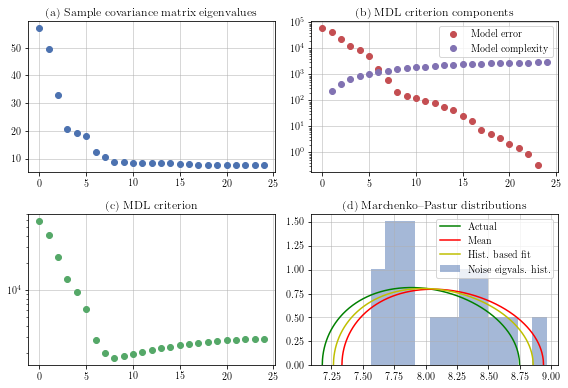

In [4]:
# general settings for signal and noise
sample_freq = 1e6  # in Hz
length = 0.01024  # in s
# length = 0.1024  # in s
signal_power = 1.0  # in dB
noise_power = 9.0  # in dB

# create the signal (the 'soft speaker' kind)
wm = ss.WirelessMicrophone(f_sample=sample_freq, t_sec=length, seed=3)
sig = wm.soft(f_center=-1e5, power=signal_power, dB=True)
sig += wm.soft(f_center=-2e5, power=signal_power+2, dB=True)
sig += wm.soft(f_center=1e5, power=signal_power-3, dB=True)
sig += wm.soft(f_center=2.5e5, power=signal_power+3, dB=True)
# sig += wm.soft(f_center=1.5e5, power=signal_power+6, dB=True)
# sig += wm.soft(f_center=-2.5e5, power=signal_power+3, dB=True)
# sig += wm.soft(f_center=2e5, power=signal_power+6, dB=True)
# sig += wm.soft(f_center=-1.5e5, power=signal_power+5, dB=True)
# sig += wm.soft(f_center=.5e5, power=signal_power+3, dB=True)
# sig += wm.soft(f_center=-.5e5, power=signal_power+2, dB=True)
# sig += wm.soft(f_center=0e5, power=signal_power+1, dB=True)

# create the noise
wgn = ss.WhiteGaussianNoise(f_sample=sample_freq, t_sec=length, seed=3340)
noise = wgn.signal(power=noise_power, dB=True)

# ensure noise and signal have same length (and create global variable 'num_samples')
assert wm.num_samples == wgn.num_samples
num_samples = wm.num_samples

# create actual signal ('both') comprising of signal and additive white Gaussian noise (AWGN)
both = sig + noise

# print some info about signal and noise
print('Signal power: %.2f dB' % (ss.util.signal_power(sig, dB=True)))
print('Noise power:  %.2f dB' % (ss.util.signal_power(noise, dB=True)))
print('SNR:          %.2f dB' % (ss.util.snr(sig, noise, dB=True)))
print('Num samples:  %d' % (num_samples))

# ensure that Parseval's theorem holds
ss.util.check_parseval(both, length, sample_freq)

def mdl_citerion_1(L, N, eigs, M):
    '''Minimum description length criterion.'''
    eigs = eigs[M:]  # select the last M eigenvalues
    prod = np.prod(eigs**(1 / (L - M)))
    summ = np.sum(eigs) / (L - M)
    return -(L - M) * N * np.log(prod / summ)


def mdl_citerion_2(L, N, eigs, M):
    '''Minimum description length criterion.'''
    eigs = eigs[M:]  # select the last M eigenvalues
    prod = np.prod(eigs**(1 / (L - M)))
    summ = np.sum(eigs) / (L - M)
    return .5 * M * (2 * L - M) * np.log(N)


def estimate_print(x,
                   n,
                   l=50,
                   res=1000,
                   dB=True,
                   prints=False,
                   true_power=None):
    '''Estimate noise power directly from covariance eigenvalues.'''
    assert len(x) == n, 'Length does not match n'
    assert len(x) > l, 'Length cant be smaller than l'

    fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(8, 5.5))

    mat = eigen_detector.corr(x, l)
    eigs = np.sort(np.abs(linalg.eigvals(mat)))[::-1]
    axs[0, 0].plot(eigs, 'o', c='C0', alpha=1., aa=True)
    axs[0, 0].set_title(r'(a) Sample covariance matrix eigenvalues')
    axs[0, 0].grid(linewidth=0.5)

    mdl1 = list(map(lambda x: mdl_citerion_1(l, n, eigs, x), np.arange(l)))
    mdl2 = list(map(lambda x: mdl_citerion_2(l, n, eigs, x), np.arange(l)))
    axs[0, 1].plot(mdl1, 'o', c='C2', alpha=1., label=r'Model error', aa=True)
    axs[0, 1].plot(mdl2,
                   'o',
                   c='C3',
                   alpha=1.,
                   label=r'Model complexity',
                   aa=True)
    axs[0, 1].set_title(r'(b) MDL criterion components')
    axs[0, 1].grid(linewidth=0.5)
    axs[0, 1].set_yscale('log')
    axs[0, 1].legend(loc=0)

    mdl = list(map(lambda x: mdl_citerion(l, n, eigs, x), np.arange(l)))
    axs[1, 0].plot(mdl, 'o', c='C1', alpha=1., aa=True)
    axs[1, 0].set_title(r'(c) MDL criterion')
    axs[1, 0].grid(linewidth=0.5)
    axs[1, 0].set_yscale('log')

    m = np.argmin(mdl)
    print('m', m)
    noise_eigs = eigs[m:]
    noise_est_mean = np.mean(noise_eigs)
    c = l / n
    beta = m / l
    pis = np.linspace(noise_eigs[-1] / (1 - c**.5)**2 * .9,
                      noise_eigs[0] / (1 + c**.5)**2 * 1.1, res)
    
    diffs_hist = list(
        map(lambda x: goodness_fit_hist(c, beta, l, noise_eigs, var=x), pis))
    noise_est_fit_hist = pis[np.argmin(diffs_hist)]

    v_truth, mp_truth = marchenko_pastur_pdf_list(
        util.dB_to_factor_power(true_power), c, res)
    v_mean, mp_mean = marchenko_pastur_pdf_list(noise_est_mean, c, res)
    v_hist, mp_hist = marchenko_pastur_pdf_list(noise_est_fit_hist, c, res)

    axs[1, 1].hist(noise_eigs,
             bins=l // 2,
             density=True,
             alpha=0.5,
             aa=True,
             label='Noise eigvals. hist.')
    axs[1, 1].plot(v_truth, mp_truth, 'g-', aa=True, label='Actual')
    axs[1, 1].plot(v_mean, mp_mean, 'r-', aa=True, label='Mean')
    axs[1, 1].plot(v_hist, mp_hist, 'y-', aa=True, label='Hist. based fit')
    axs[1, 1].set_title(r'(d) Marchenko–Pastur distributions')
    axs[1, 1].grid(linewidth=0.5)
    axs[1, 1].legend(loc=0)

    plt.tight_layout()
    plt.savefig('out/chap5/eigenvalue_noise_estimation.pdf')


estimate_print(both, num_samples, l=25, prints=True, true_power=noise_power)